**Newton method for Oscillator**

Dr. Lilli Frison, Florian Messerer, Pro. Dr. Moritz Diehl
12\. May 2023

Load Python packages

In [1]:
import os
import shutil
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

Helpfer functions for plotting

In [2]:
# set to True if all plots should be merged into one pdf
# needs PyPDF2 package installed (pip install PyPDF2)
merge_pdfs = False      
if merge_pdfs:
    from PyPDF2 import PdfMerger

# for latex fonts in plot. needs latex installed.
use_latex_fonts = False
if use_latex_fonts:
    from latexify import latexify
    latexify(fig_width=3.5, fig_height=1.5)
    
colors = ['black', 'lightgray']

def plotTraj(X, U, T=1, filename=None, integrator=None,title=None):

    N = U.shape[1]
    nx = X.shape[0]
    time_vec = np.linspace(0, T, N+1)

    plt.figure(figsize=(10,2))
    plt.subplot(121)
    if integrator is not None:
        for k in range(N):
            X_inter = integrator(X[:,k], U[:,k]).full()
            N_inter = X_inter.shape[1]
            X_inter = np.concatenate((X[:, k][:,None], X_inter), axis=1)
            time_vec_inter = time_vec[k] + np.linspace(0, T/N, N_inter+1)
            plt.plot(time_vec_inter, X_inter[0,:], color=colors[0])
            plt.plot(time_vec_inter, X_inter[1,:], color=colors[1])
    else:
        plt.plot(time_vec, X[0,:])
        plt.plot(time_vec, X[1,:])
    
    plt.plot(time_vec, X[0,:], '.', color=colors[0], label=r'Position $p$')
    plt.plot(time_vec, X[1,:], '.', color=colors[1], label=r'Geschwindigkeit $v$')

    plt.ylim([-2.2, 2.2])
    plt.xlim([0, T])
    plt.legend()
    plt.title(title)
    plt.xticks([])

    plt.subplot(122)
    plt.step(time_vec, np.concatenate((U[0,:], [np.nan]), axis=0), label=r'Steuerung $a$', where='post', color=colors[0])
    plt.legend()
    plt.xlabel(r'Zeit $t$')
    plt.ylim([-2, 2])
    plt.xlim([0, T])

    if filename is not None:
        plt.tight_layout()
        plt.tight_layout(pad=0)
        plt.savefig( filename )


# Function definitions

### Define problem parameters and ODE

In [3]:
# problem parameters
T = 4               # continous time horizon
N = 30              # discrete time horizon
dt = T/N            # time step / control discretization
N_int = 10          # number of integrator steps per time step

# define states and control for ode
ns = 2              # number of states
na = 1              # number of actions
s = ca.SX.sym('x', ns)          # symbol for state
a = ca.SX.sym('u', na)          # symbol for action

s0bar = np.array([2, 0])        # initial state
sNbar = np.array([0, 0])        # target state

# define decision variables for NLP (from states and controls)
a_all = ca.SX.sym('a_all', na, N)       # all controls
s_all = ca.SX.sym('s_all', ns, N+1)     # all states
x = ca.veccat(a_all, s_all)             # all decision variables together
nx = x.shape[0]       

### Forth order Runge Kutta method to discretize the differential equations

Return integrator $s_{i+1}=G_{h}^{\operatorname{lin}}\left(s_{i}, a_{i}\right)$ or $s_{i+1}=G_{h}^{\operatorname{nonlin}}\left(s_{i}, a_{i}\right)$

In [4]:
def rk4step(ode, h, x, u):

    k1 = ode(x, u)
    k2 = ode(x + h/2 * k1, u)
    k3 = ode(x + h/2 * k2, u)
    k4 = ode(x + h * k3, u)
    x_next = x + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    return x_next

def get_integrator(ode):
    # define integrator of dynamics
    # Runge-Kutta 4th order integrator
    s_next = rk4step(ode, dt/N_int, s, a)                   # as casadi expression
    rk4_step = ca.Function('rk4_step', [s, a], [s_next])    # as casadi function
    # apply function rk4_step() N_int times on itself
    integrator = rk4_step.mapaccum(N_int)  
    
    return integrator

### Implementation of Newton Method for equality constrained optimization

In [6]:
def newton_method(F, z0, tol=1e-12, max_iter=100):
    """
    Newton's method for solving F(z) = 0

    F is a function with n inputs and n outputs
    z0 is the initial guess, such that z0.shape = (n,)
    tol is the convergence tolerance (infinity norm of F(z))
    max_iter is the maximum number of iterations
    """

    n = z0.shape[0]
    z = ca.SX.sym('z', n)           # symbolic variable for input z
    z_iters = [z0]                  # save all iterations of z in this list

    # compute Jacobian of F, wrap into Function
    J = ca.Function('J',[z], [ca.jacobian(F(z), z)])

    # iteration loop
    for k in range(max_iter):
        z_prev = z_iters[-1]
        
        # compute current value of F and check for convergence
        F_prev = F(z_prev).full()
        print('Iteration',k,'- erro',np.linalg.norm(F_prev, np.infty))
        if np.linalg.norm(F_prev, np.infty) < tol:
            # we have found a solution
            break

        # compute next guess by solving linearized system
        z_next = z_prev - ca.solve(J(z_prev), F_prev)
        z_iters.append(z_next.full())
        

    if k == max_iter - 1:
        print('max iter reached')
    else:
        print('converged in {} iterations'.format(k))

    return z_iters

### Plot solution

In [7]:
def plot_solution(z):
    # go through all iterations and visualize (saves plots to pdfs)
    filenames = []
    for i, iter in enumerate(iters):
        X_ = ca.evalf(ca.substitute(s_all, z, iter)).full()
        U_ = ca.evalf(ca.substitute(a_all, z, iter)).full()
        filename = outfolder + '/iter_{}.pdf'.format(i)
        filenames.append(filename)
        if not nonlinear_dyn and not control_penalty_steep:
            title = None
        else:
            title = 'Iteration {}'.format(i)
        plotTraj(X_, U_, T, filename=filename, integrator=integrator, title=title)

    if merge_pdfs:
        print('Concatenating all pdfs...')
        merger = PdfMerger()
        for pdf in filenames:
            merger.append(pdf)
        merger.write(outfolder +'/iter_all.pdf')
        merger.close()
        print('Done.')

### Assemble NLP

In [8]:
def define_NLP(integrator,control_penalty_steep):

    # objective function
    obj = 0
    for i in range(N):
        obj += a_all[:,i]**2
        obj += .01 * s_all[0,i]**2
    if control_penalty_steep:
        for i in range(N):
            obj += a_all[:,i]**4

    # constraints
    constr = []
    constr.append(s_all[:,0] - s0bar)           # initial condition
    for i in range(N):                          # dynamics        
        constr.append(s_all[:,i+1] - integrator(s_all[:,i], a_all[:,i])[:,-1])
    constr.append(s_all[:,N] - sNbar)           # terminal constraint

    c = ca.veccat(*constr)                  # all equality constraints together
    nc = c.shape[0]                         # number of (scalar) equality constraints

    lam = ca.SX.sym('lam', nc)              # lagrange multiplier of equality constraints
    Lagrangian = obj - lam.T @ c            # Lagrangian
    nab_Lag = ca.gradient(Lagrangian, x)    # gradient of Lagrangian

    # root finding problem (F(z) = 0)
    z = ca.vertcat(x, lam)                  # all variables
    F = ca.Function('F', [z], [ca.vertcat(nab_Lag, c)])
    
    return F, z, nc

# Example 1: Spring-mass system

Often we cannot directly specify the force acting on a body, but can only transmit it to the body by means of an elastic element, e.g. a spring.

Application: Railway engineering: Spring components can be inserted between the superstructure of railway tracks and the subsoil (e.g. concreted tunnel floor) so that vibrations emanating from the vehicles do not spread into the surroundings and are not perceived there as structure-borne noise.

We consider a simple oscillator in the form of a mass-spring system, i.e., a mass, which is attached to a spring. The mass lies on a surface and has position $p \in R$. The other side of the spring has position a ∈ R.
The other side of the spring has position $a \in R$, which we can choose freely and change as quickly as we like.
We can change this position as quickly as we like. If we combine position $p$ and its velocity $v$ in the state vector $s = (p, v)$, we can calculate the dynamics of the spring.
We can describe the dynamics of the system by the linear, second-order ODE:
$$
\left[\begin{array}{c}
\dot{p} \\
\dot{v}
\end{array}\right]=\left[\begin{array}{c}
v \\
k_{\text {Feder }}(a-p)
\end{array}\right].
$$


Objective: to stabilise the system, starting at the initial position $s_0 = (2, 0)$, at the origin, so that
$s_N = (0, 0)$. 

In particular, we want to keep the control effort small, but we also have a slight preference for the fact that
a slight preference for the position to be as early as possible at 0.


In [9]:
# system parameters
k_spring = 1        # spring constant
a_grav = 1          # gravity acceleration
L = 1               # pendulum length

## Quadratic problem formulation (convex)


$$
\begin{aligned}
& \min _{\substack{s_{0}, \ldots, s_{N} \in \mathbb{R}^{2} \\
a_{0}, \ldots, a_{N-1} \in \mathbb{R}}} \sum_{i=0}^{N-1} a_{i}^{2}+0.01 p_{i}^{2} \\
& \text { s.t. } \\
& s_{0}=\bar{s}_{0}, \\
& s_{i+1}=G_{h}^{\operatorname{lin}}\left(s_{i}, a_{i}\right), \quad i=0, \ldots, N-1, \\
& s_{N}=0 \text { }
\end{aligned}
$$
where
$$
s_{i+1}=G_{h}^{\operatorname{lin}}\left(s_{i}, a_{i}\right)
$$
obtained by a Runge Kutta order 4 discretization of the ODE
$$
\dot{s}=\left[\begin{array}{c}
\dot{p} \\
\dot{v}
\end{array}\right]=\left[\begin{array}{c}
v \\
k_{\text {Feder }}(a-p)
\end{array}\right]=: g^{\operatorname{lin}}(s, a).
$$

System parameters: spring constant $k_{\text {Feder }}=1$

Problem parameters: Time horizon $T=4$, sample length $h=T/N$, discretization steps ODE $N=30$ 


Iteration 0 - erro 2.0
Iteration 1 - erro 2.0056872829243844e-14
converged in 1 iterations


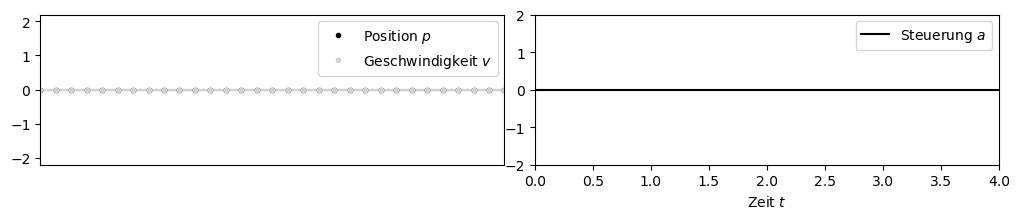

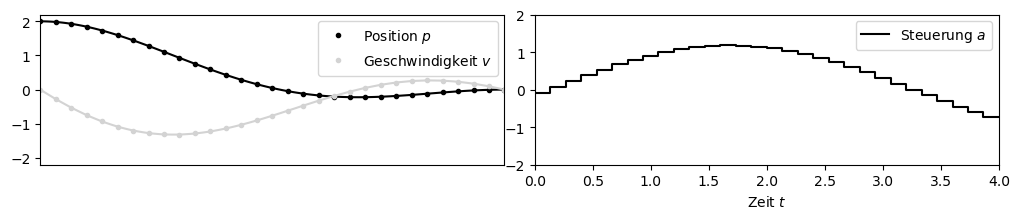

In [10]:
## Settings and output folder

nonlinear_dyn = False            # set to True for nonlinear dynamics
control_penalty_steep = False    # set to True for steep control penalty (a^4)

# folder for saving results
outfolder = 'results/'
if nonlinear_dyn:
    outfolder += 'nl_dyn'
else:
    outfolder += 'lin_dyn'
if control_penalty_steep:
    outfolder += '_steep_contr_pen'
if os.path.exists(outfolder):
    shutil.rmtree(outfolder, ignore_errors=False, onerror=None)
os.makedirs(outfolder)

## Define ODE

p = s[0]                        # position
v = s[1]                        # velocity

pdot = v                        # time derivative of position is velocity
if nonlinear_dyn:
    vdot = a_grav * ca.sin((a-p / L))
else:
    vdot = k_spring * (a - p)

sdot = ca.veccat(pdot, vdot )               # time derivative of state / ode
ode = ca.Function('ode', [s, a], [ sdot ])  # as function

## Apply Newton Method 

# get discretized system from ODE
integrator = get_integrator(ode)
    
# get NLP    
F, z, nc = define_NLP(integrator,control_penalty_steep)

# solve root finding problem using newtons method
iters = newton_method(F, np.zeros(nx+nc))

# plot solution
plot_solution(z)

## Convex formulation 2

Avoid controls that deviate from 0 even more by adding another control penalty $a^4$ to ojective (control_penalty_steep=True).

$$
\begin{aligned}
& \min _{\substack{s_{0}, \ldots, s_{N} \in \mathbb{R}^{2} \\
a_{0}, \ldots, a_{N-1} \in \mathbb{R}}} \sum_{i=0}^{N-1} a_{i}^{2}+a_{i}^{4}+0.01 p_{i}^{2} \\
& \text { s.t. } \quad s_{0}=\bar{s}_{0} \text {, } \\
& s_{i+1}=G_{h}^{\operatorname{lin}}\left(s_{i}, a_{i}\right), \quad i=0, \ldots, N-1, \\
& s_{N}=0 \text {. }
\end{aligned}
$$

Iteration 0 - erro 2.0
Iteration 1 - erro 6.516836184982729
Iteration 2 - erro 0.556212005741519
Iteration 3 - erro 0.03241947409247059
Iteration 4 - erro 0.00016325291036523026
Iteration 5 - erro 4.4852739300438316e-09
Iteration 6 - erro 5.684341886080802e-14
converged in 6 iterations


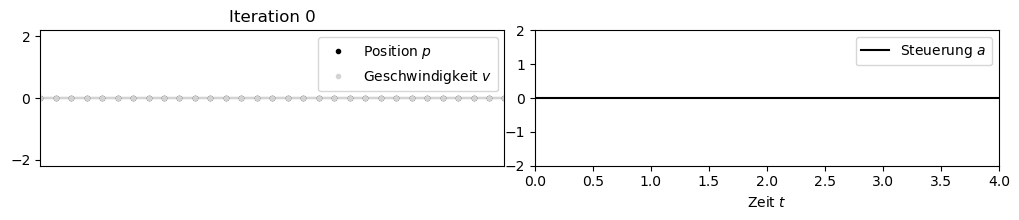

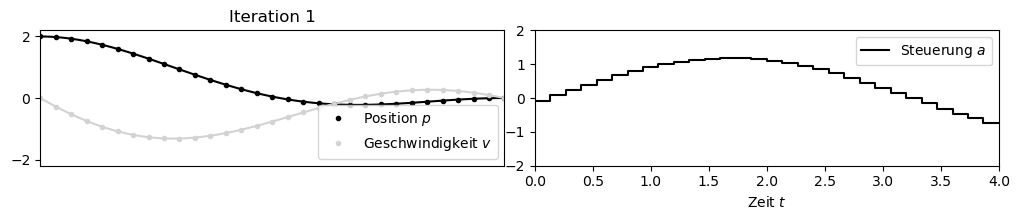

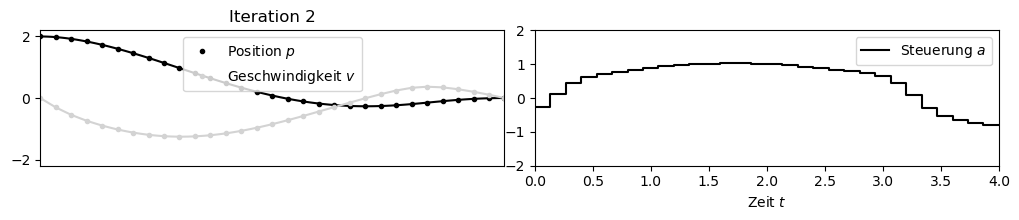

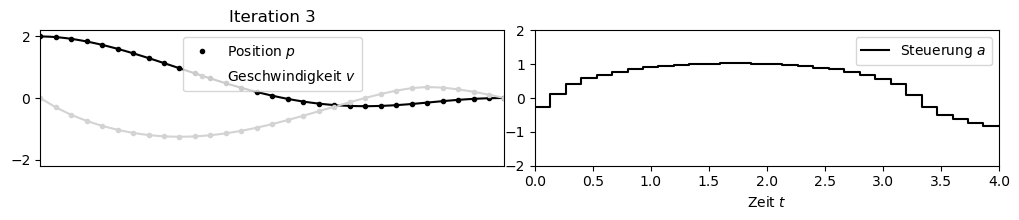

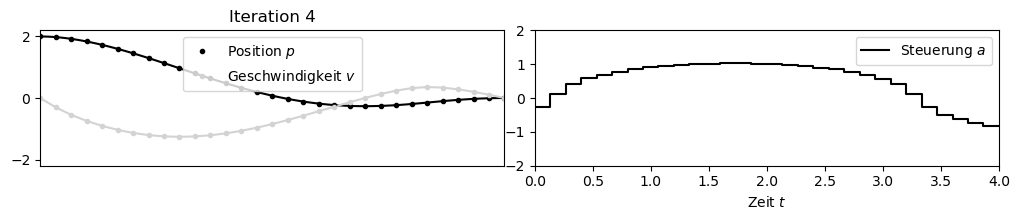

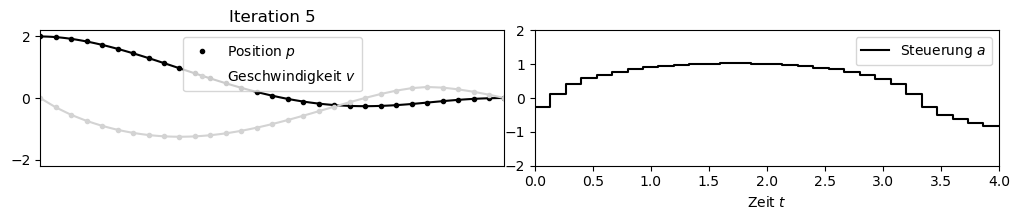

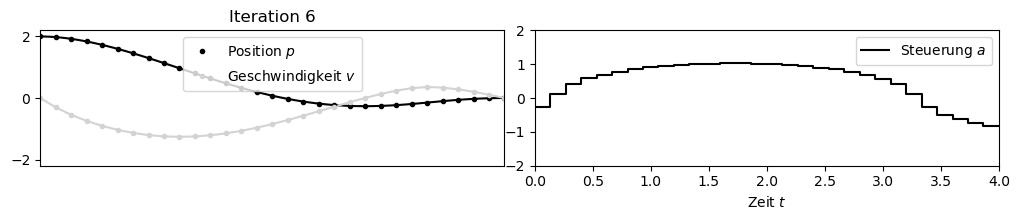

In [11]:
## Settings and output folder

nonlinear_dyn = False            # set to True for nonlinear dynamics
control_penalty_steep = True    # set to True for steep control penalty (a^4)

# folder for saving results
outfolder = 'results/'
if nonlinear_dyn:
    outfolder += 'nl_dyn'
else:
    outfolder += 'lin_dyn'
if control_penalty_steep:
    outfolder += '_steep_contr_pen'
if os.path.exists(outfolder):
    shutil.rmtree(outfolder, ignore_errors=False, onerror=None)
os.makedirs(outfolder)

## Define ODE

p = s[0]                        # position
v = s[1]                        # velocity

pdot = v                        # time derivative of position is velocity
if nonlinear_dyn:
    vdot = a_grav * ca.sin((a-p / L))
else:
    vdot = k_spring * (a - p)

sdot = ca.veccat(pdot, vdot )               # time derivative of state / ode
ode = ca.Function('ode', [s, a], [ sdot ])  # as function

## Apply Newton Method 

# get discretized system from ODE
integrator = get_integrator(ode)
    
# get NLP    
F, z, nc = define_NLP(integrator,control_penalty_steep)

# solve root finding problem using newtons method
iters = newton_method(F, np.zeros(nx+nc))

# plot solution
plot_solution(z)

# Example 2: Pendulum

We replace the mass-spring system with a pendulum (a mass suspended from a fixed rod). 
The state is still $x=(p, v)$. 
However, now the position $p$ corresponds to the horizontal position of the mass, and the control $a$ corresponds to the horizontal position of the pendulum suspension, so that at $p=a$ the mass is exactly under the suspension. The dynamics is then given by

$$
\dot{s}=\left[\begin{array}{c}
\dot{p} \\
\dot{v}
\end{array}\right]=\left[\begin{array}{c}
v \\
a_{\text {gravity }} \sin \left(\frac{a-p}{L}\right)
\end{array}\right]=: g^{\mathrm{nonlin}}(s, a),
$$

with pendulum length $L=1$ and gravitational acceleration $a_{\text {gravity }}$. We note that this is only an approximate model where the error becomes negligible only for small deflections $|a-p|$. In contrast to the mass-spring system, the dynamics is now non-linear.


Objective: to stabilise the system, starting at the initial position $s_0 = (2, 0)$, at the origin, so that
$s_N = (0, 0)$. 

In particular, we want to keep the control effort small, but we also have a slight preference for the fact that
a slight preference for the position to be as early as possible at 0.


## Nonconvex formulation 1

$$
\begin{aligned}
& \min _{\substack{s_{0}, \ldots, s_{N} \in \mathbb{R}^{2} \\
a_{0}, \ldots, a_{N-1} \in \mathbb{R}}} \sum_{i=0}^{N-1} a_{i}^{2}+0.01 p_{i}^{2} \\
& \text { s.t. } \quad s_{0}=\bar{s}_{0} \text {, } \\
& s_{i+1}=G_{h}^{\mathrm{nonlin}}\left(s_{i}, a_{i}\right), \quad i=0, \ldots, N-1, \\
& s_{N}=0 \text {, }
\end{aligned}
$$

Iteration 0 - erro 2.0
Iteration 1 - erro 1.1937710260936114
Iteration 2 - erro 0.24674433955319497
Iteration 3 - erro 0.07916076101985584
Iteration 4 - erro 0.012475008183144357
Iteration 5 - erro 0.00015522895680486481
Iteration 6 - erro 7.723262240161288e-08
Iteration 7 - erro 3.197442310920451e-14
converged in 7 iterations


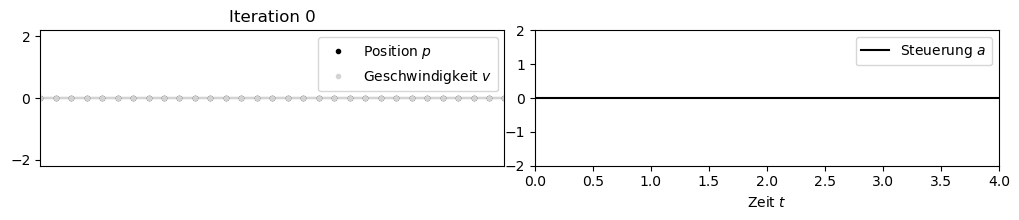

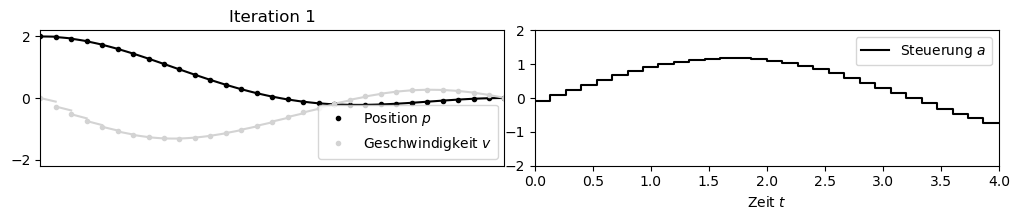

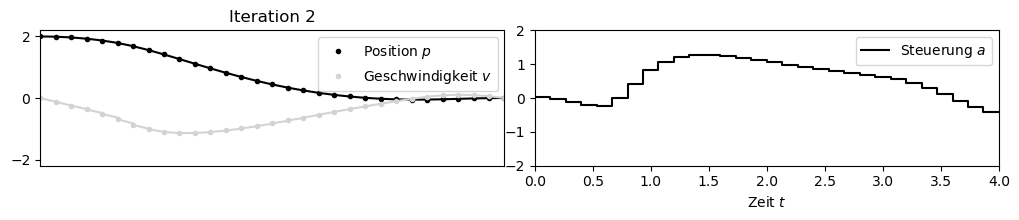

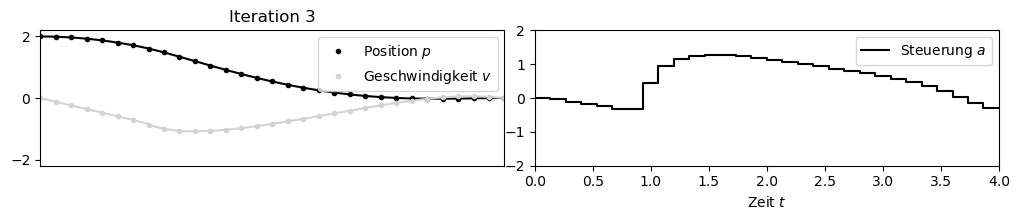

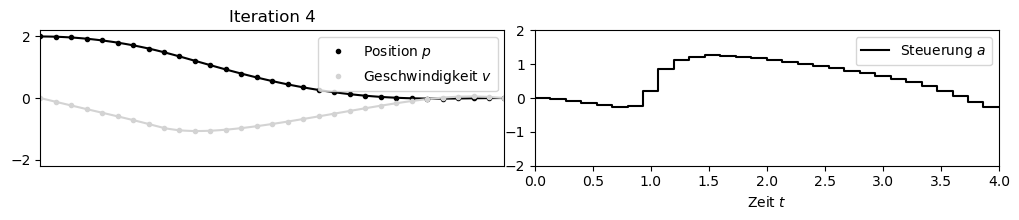

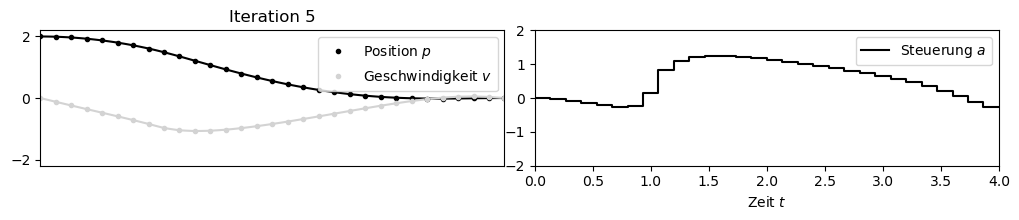

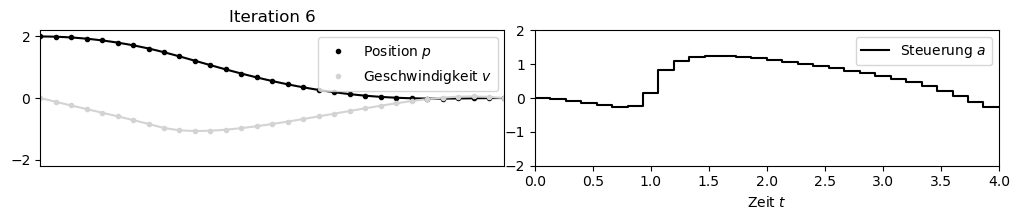

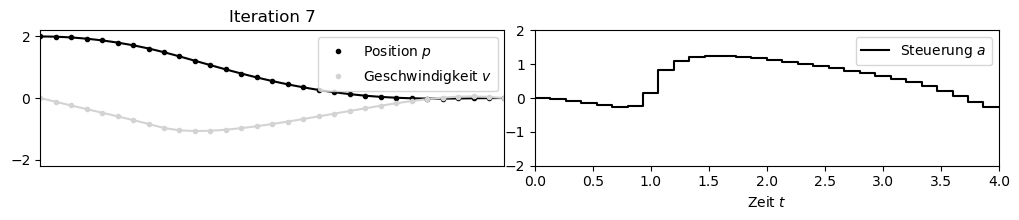

In [15]:
## Settings and output folder

nonlinear_dyn = True            # set to True for nonlinear dynamics
control_penalty_steep = False    # set to True for steep control penalty (a^4)

# folder for saving results
outfolder = 'results/'
if nonlinear_dyn:
    outfolder += 'nl_dyn'
else:
    outfolder += 'lin_dyn'
if control_penalty_steep:
    outfolder += '_steep_contr_pen'
if os.path.exists(outfolder):
    shutil.rmtree(outfolder, ignore_errors=False, onerror=None)
os.makedirs(outfolder)

## Define ODE

p = s[0]                        # position
v = s[1]                        # velocity

pdot = v                        # time derivative of position is velocity
if nonlinear_dyn:
    vdot = a_grav * ca.sin((a-p / L))
else:
    vdot = k_spring * (a - p)

sdot = ca.veccat(pdot, vdot )               # time derivative of state / ode
ode = ca.Function('ode', [s, a], [ sdot ])  # as function

## Apply Newton Method 

# get discretized system from ODE
integrator = get_integrator(ode)
    
# get NLP    
F, z, nc = define_NLP(integrator,control_penalty_steep)

# solve root finding problem using newtons method
iters = newton_method(F, np.zeros(nx+nc))

# plot solution
plot_solution(z)

## Nonconvex formulation 2

Additional control penality $a^{4}$ in objective (control_penalty_steep=True)

$$
\begin{aligned}
& \min _{\substack{s_{0}, \ldots, s_{N} \in \mathbb{R}^{2} \\
a_{0}, \ldots, a_{N-1} \in \mathbb{R}}} \sum_{i=0}^{N-1} a_{i}^{2}+a_{i}^{4}+0.01 p_{i}^{2} \\
& \text { s.t. } \quad s_{0}=\bar{s}_{0} \text {, } \\
& s_{i+1}=G_{h}^{\mathrm{nonlin}}\left(s_{i}, a_{i}\right), \quad i=0, \ldots, N-1, \\
& s_{N}=0 \text {, }
\end{aligned}
$$


Iteration 0 - erro 2.0
Iteration 1 - erro 7.3977627893408675
Iteration 2 - erro 4.662229800250895
Iteration 3 - erro 5808.625545930446
Iteration 4 - erro 20867.42691732654
Iteration 5 - erro 6185.3136741595445
Iteration 6 - erro 1832.7550088046282
Iteration 7 - erro 547.7962521938284
Iteration 8 - erro 161.1300541155943
Iteration 9 - erro 47.29891930705104
Iteration 10 - erro 13.282585705665781
Iteration 11 - erro 3.6390050899593955
Iteration 12 - erro 0.8631639414116683
Iteration 13 - erro 0.12807526386005974
Iteration 14 - erro 0.005213941473552142
Iteration 15 - erro 1.0304513598846654e-05
Iteration 16 - erro 4.117350904664363e-11
Iteration 17 - erro 3.552713678800501e-14
converged in 17 iterations


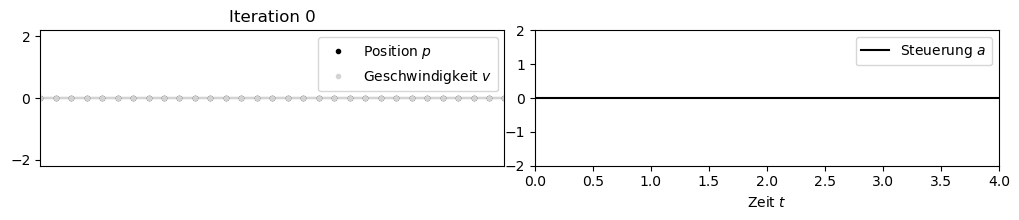

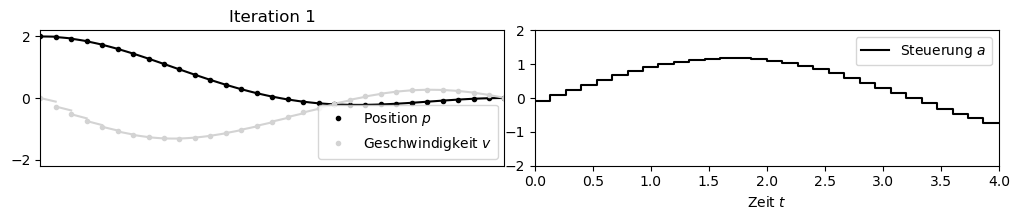

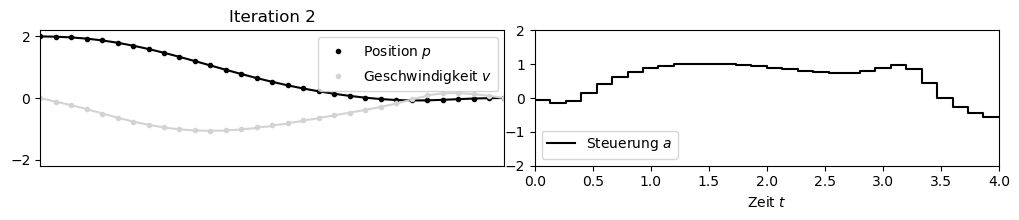

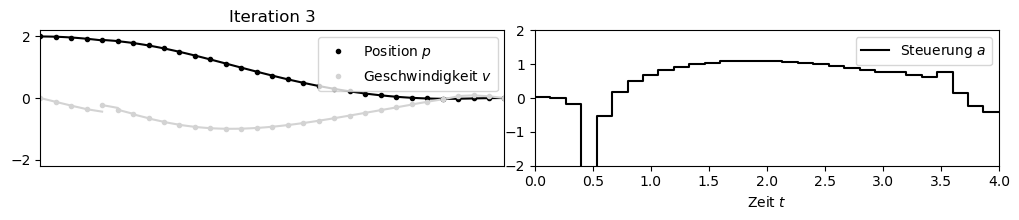

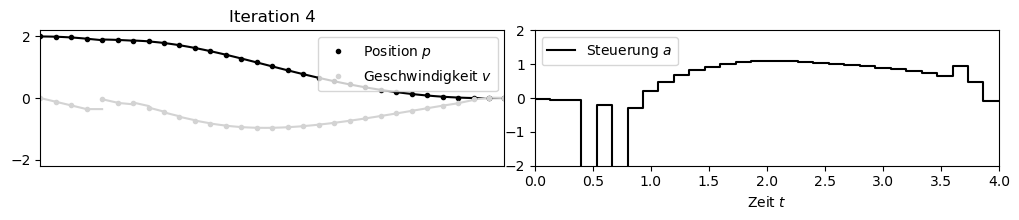

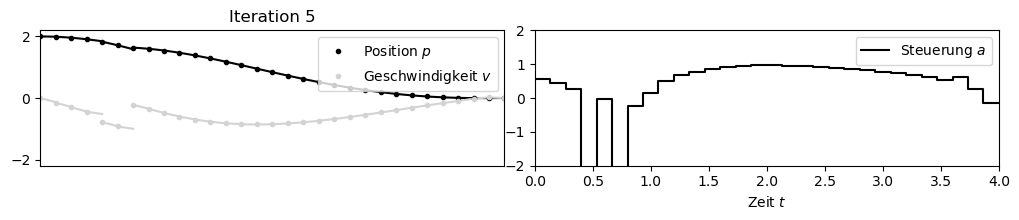

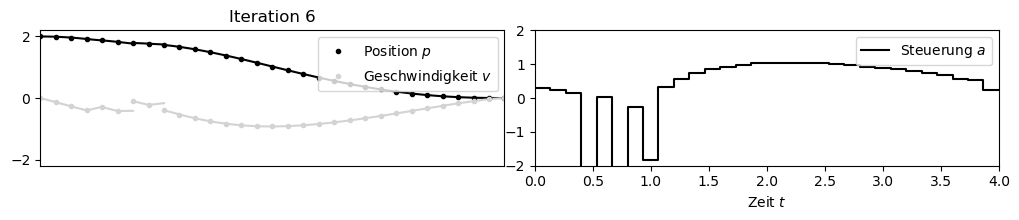

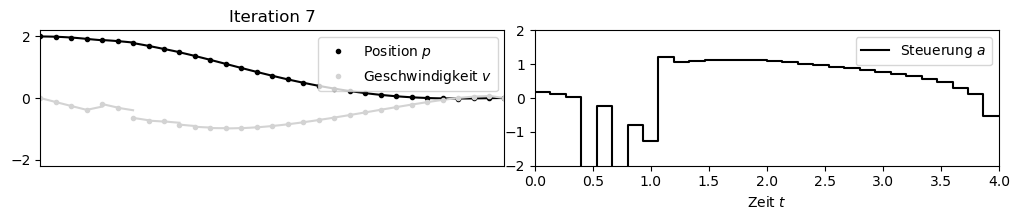

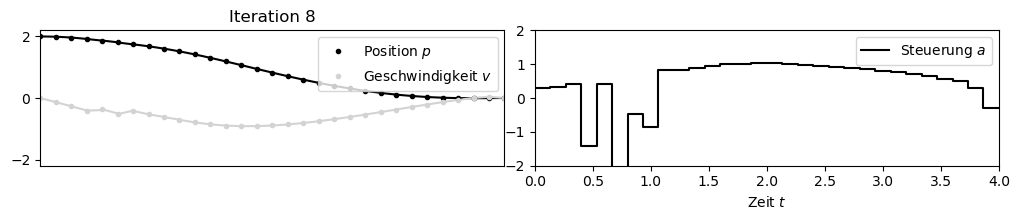

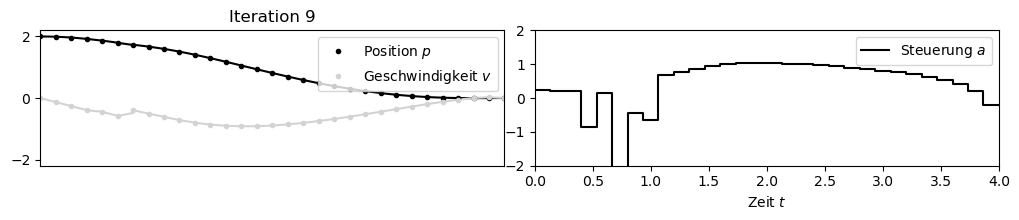

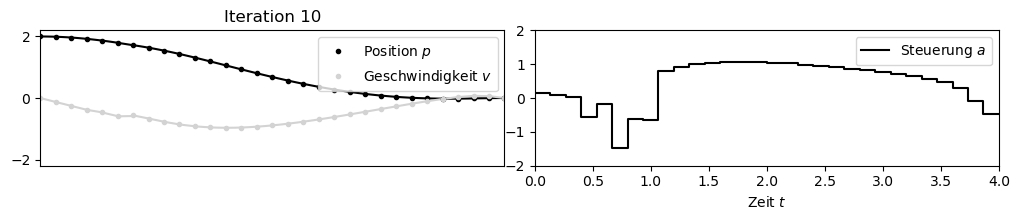

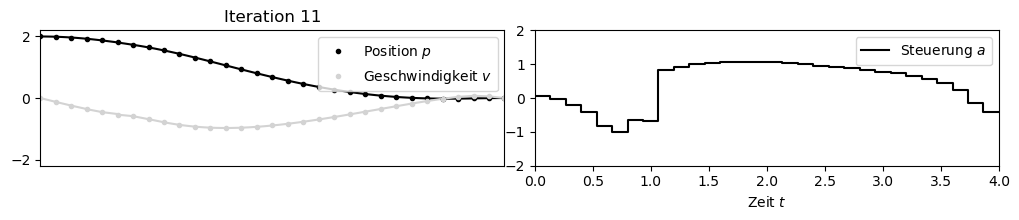

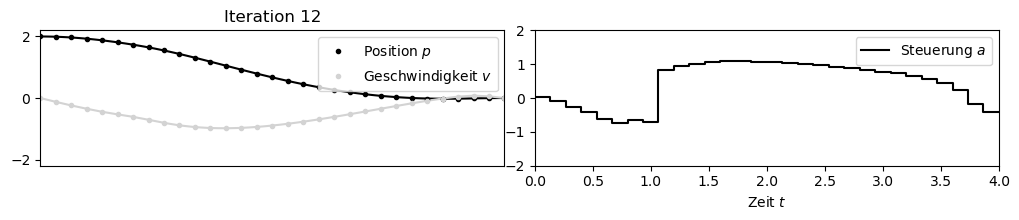

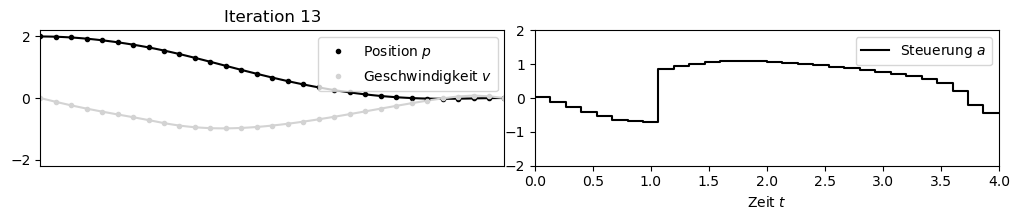

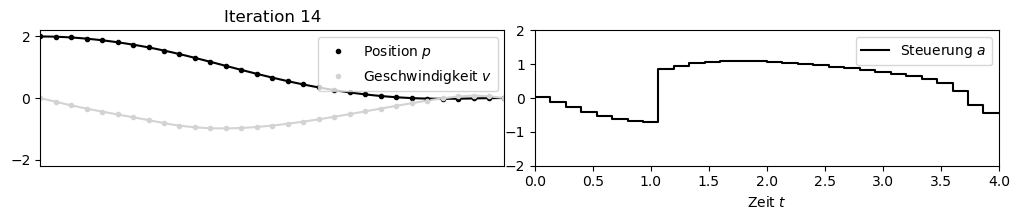

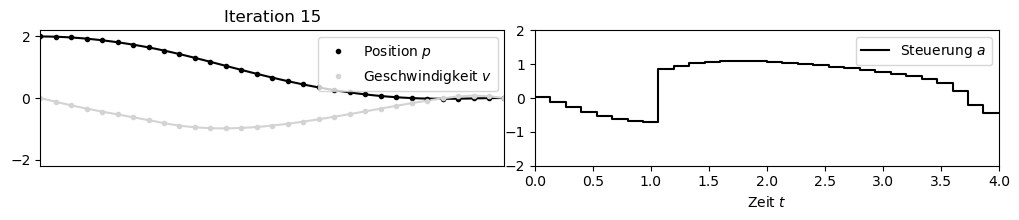

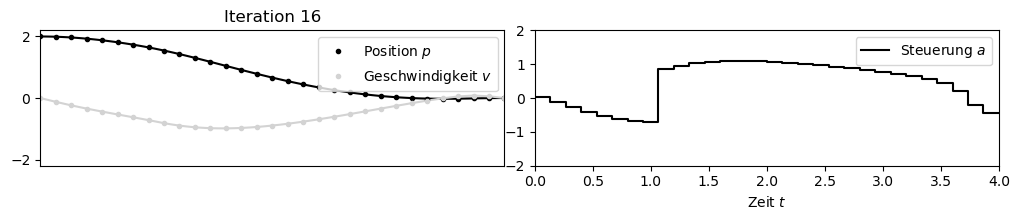

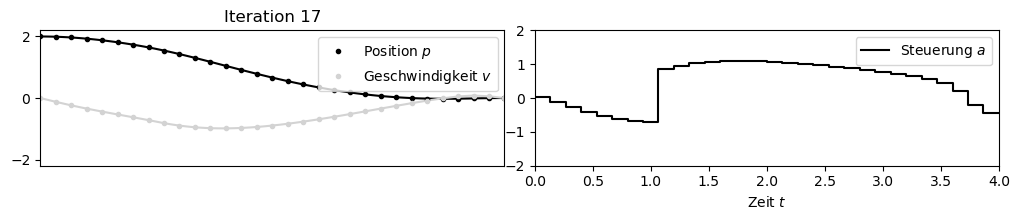

In [16]:
## Settings and output folder

nonlinear_dyn = True            # set to True for nonlinear dynamics
control_penalty_steep = True    # set to True for steep control penalty (a^4)

# folder for saving results
outfolder = 'results/'
if nonlinear_dyn:
    outfolder += 'nl_dyn'
else:
    outfolder += 'lin_dyn'
if control_penalty_steep:
    outfolder += '_steep_contr_pen'
if os.path.exists(outfolder):
    shutil.rmtree(outfolder, ignore_errors=False, onerror=None)
os.makedirs(outfolder)

## Define ODE

p = s[0]                        # position
v = s[1]                        # velocity

pdot = v                        # time derivative of position is velocity
if nonlinear_dyn:
    vdot = a_grav * ca.sin((a-p / L))
else:
    vdot = k_spring * (a - p)

sdot = ca.veccat(pdot, vdot )               # time derivative of state / ode
ode = ca.Function('ode', [s, a], [ sdot ])  # as function

## Apply Newton Method 

# get discretized system from ODE
integrator = get_integrator(ode)
    
# get NLP    
F, z, nc = define_NLP(integrator,control_penalty_steep)

# solve root finding problem using newtons method
iters = newton_method(F, np.zeros(nx+nc))

# plot solution
plot_solution(z)